In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from pymono.config import CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX

In [46]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [85]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plot_h3d, plot_energies2
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [115]:
from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [25]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX

- Study performance of a CsI monolithic crystal.
- Compare Conv and Resnet

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 50 k photons per point (pure CsI, with ~100 k photons/MeV)
- 0MHzDC (Cold CsI, no DC)
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation 

## Setup

In [10]:
imgs, mdata = select_image_and_lbl(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, 9)

Selected files: img = images_25.npy, metdata = metadata_25.csv


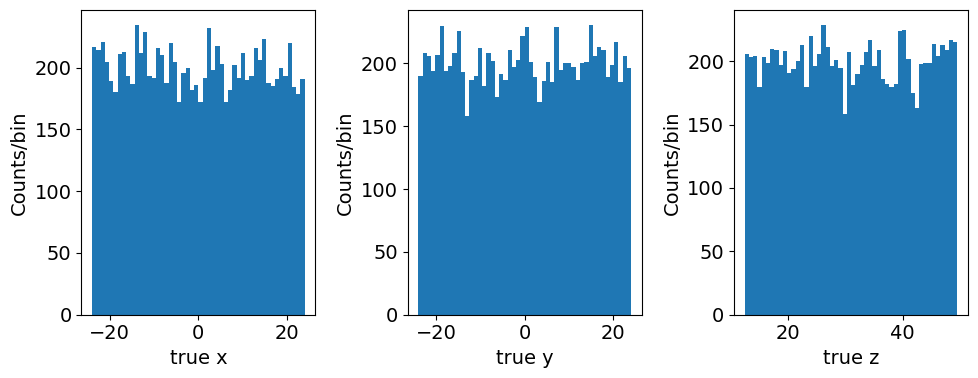

In [11]:
plot_true_positions(mdata)

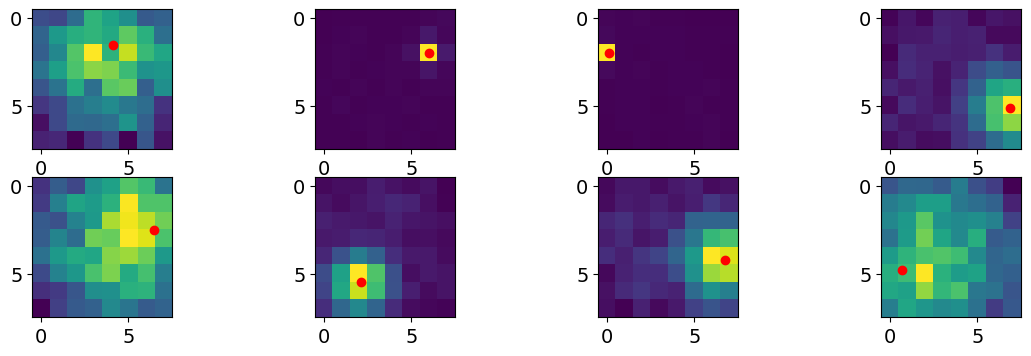

In [12]:
plot_images(imgs, mdata, range(0,8))

In [13]:
imgs[0]

array([[138., 135., 155., 199., 188., 176., 145., 149.],
       [151., 182., 195., 199., 192., 213., 196., 157.],
       [148., 171., 210., 249., 198., 236., 202., 190.],
       [160., 186., 208., 224., 221., 203., 178., 181.],
       [142., 159., 193., 157., 212., 216., 148., 176.],
       [127., 136., 158., 166., 174., 162., 156., 125.],
       [110., 136., 154., 153., 157., 179., 149., 119.],
       [118., 120., 105., 125., 136., 104., 143., 111.]], dtype=float32)

In [14]:
np.mean(imgs[0])

166.57812

In [15]:
np.std(imgs[0])

33.971405

In [17]:
energy = get_energy(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, 9)

Selected files: img = images_25.npy, metdata = metadata_25.csv


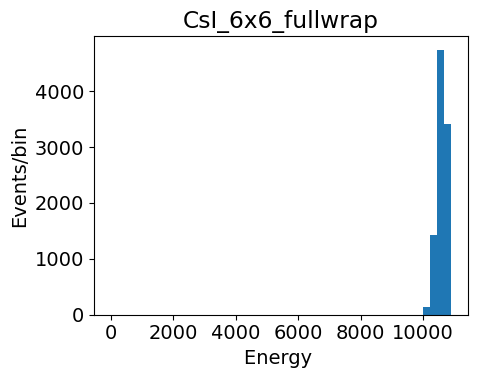

In [18]:
plot_energies2({"CsI_6x6_fullwrap":energy}, xmin=0, xmax=max(energy),num_bins = 50)

In [19]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} resolution (FWHM)  = {100*fwhm6x6:.2f} %")

mean = 10616.38 resolution (FWHM)  = 3.47 %


## Data set

In [21]:
first_file = 0  # initial file indx
last_file  = 30  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [37]:
dataset = MonoDataset(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, first_file, last_file)


Running Monoataset with norm = (False,), resize=False
Loading files with indexes: [ 1  2  3  4 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [38]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 300000 events
 train size = 210000
 val size = 60000
 test size = 30000
 train indices = range(0, 210000)
 val indices = range(210000, 270000)
 test indices = range(270000, 300000)
210000 training events (70.0%)
60000 validation events (20.0%)
30000 test events (10.0%)


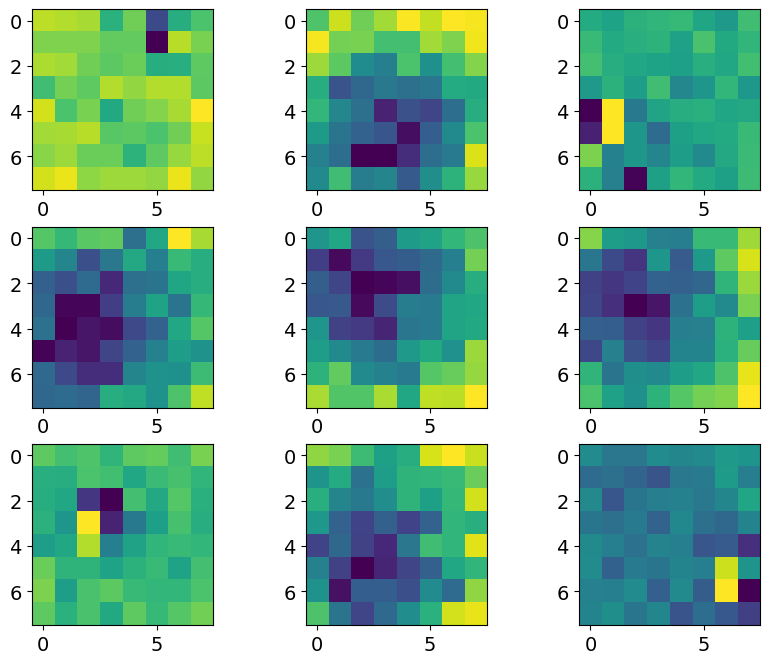

In [39]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [40]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 3])
tensor([[142., 170., 158., 161., 132., 128., 132., 111.],
        [159., 179., 203., 194., 188., 167., 130., 125.],
        [176., 196., 198., 183., 161., 175., 173., 130.],
        [188., 224., 226., 193., 185., 149., 139., 149.],
        [166., 221., 206., 192., 175., 182., 173., 146.],
        [162., 195., 223., 174., 186., 173., 153., 128.],
        [158., 156., 190., 173., 182., 169., 147., 125.],
        [155., 159., 168., 171., 148., 138., 130., 119.]])


### Train the network with CNN_basic 

In [41]:
# Load the model.
model = CNN_3x3(dropout=False).to(device)
print(model)

CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [42]:
# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()


In [43]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
input data shape =>torch.Size([1000, 1, 8, 8])
(16,16,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/210, Loss: 466.4169921875
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/210, Loss: 474.10382080078125


In [44]:
epochs = 10

In [45]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=50)

Training with  ->210000 images
size of train loader  ->210 images
Evaluating with  ->60000 images
size of eval loader  ->60 images
Running for epochs ->10

EPOCH 0
Train Step 50/210, Loss: 228.22093200683594
Train Step 100/210, Loss: 148.6232452392578
Train Step 150/210, Loss: 116.12116241455078
Train Step 200/210, Loss: 77.40899658203125
Validation Step 50/60, Loss: 69.58845520019531
--- EPOCH 0 AVG TRAIN LOSS: 176.36800500778924
--- EPOCH 0 AVG VAL LOSS: 68.581494140625

EPOCH 1
Train Step 50/210, Loss: 46.67026901245117
Train Step 100/210, Loss: 32.206600189208984
Train Step 150/210, Loss: 20.309120178222656
Train Step 200/210, Loss: 14.056317329406738
Validation Step 50/60, Loss: 13.387500762939453
--- EPOCH 1 AVG TRAIN LOSS: 33.62512080328805
--- EPOCH 1 AVG VAL LOSS: 12.778037643432617

EPOCH 2
Train Step 50/210, Loss: 10.187638282775879
Train Step 100/210, Loss: 7.067930221557617
Train Step 150/210, Loss: 6.827786445617676
Train Step 200/210, Loss: 6.031561851501465
Validation S

In [52]:
def plot_loss(epochs, train_losses, val_losses,figsize=(10, 4)):
    
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    xvals_train = np.arange(0,epochs,1)
    xvals_val = np.arange(0,epochs,1)
    plt.plot(xvals_train,train_losses,label='training')
    plt.plot(xvals_val,val_losses,label='validation')
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

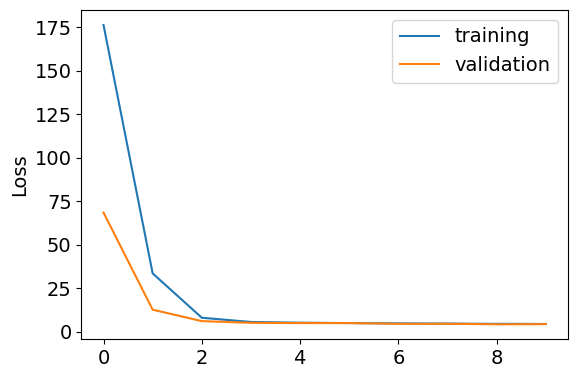

In [55]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))


In [48]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6)

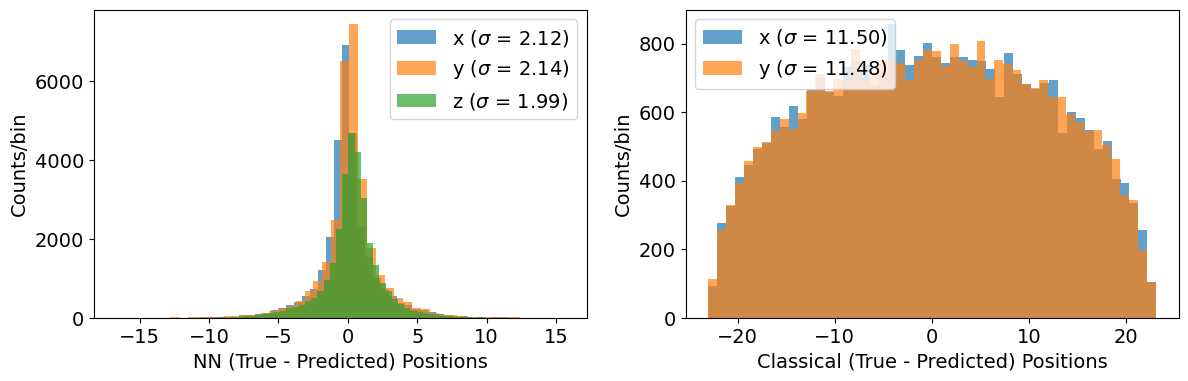

In [49]:
plot_true_predicted(tdeltas, nbins = 50)

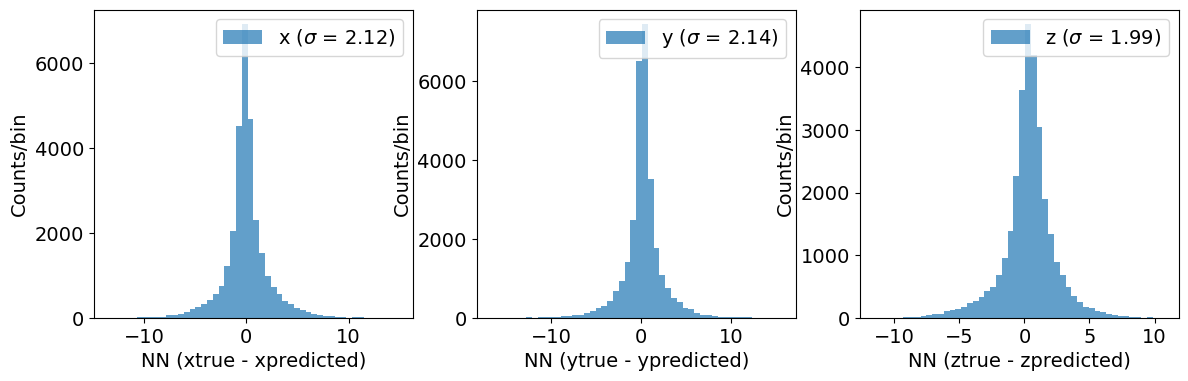

In [50]:
plotxyz(tdeltas, nbins=50)

## Normalize

In [58]:
dataset = MonoDataset(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, 
                      first_file, last_file,
                      norm=True, resize=False, mean=165.90, std=93.3)


Running Monoataset with norm = True, resize=False
Loading files with indexes: [ 1  2  3  4 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [59]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 300000 events
 train size = 210000
 val size = 60000
 test size = 30000
 train indices = range(0, 210000)
 val indices = range(210000, 270000)
 test indices = range(270000, 300000)
210000 training events (70.0%)
60000 validation events (20.0%)
30000 test events (10.0%)


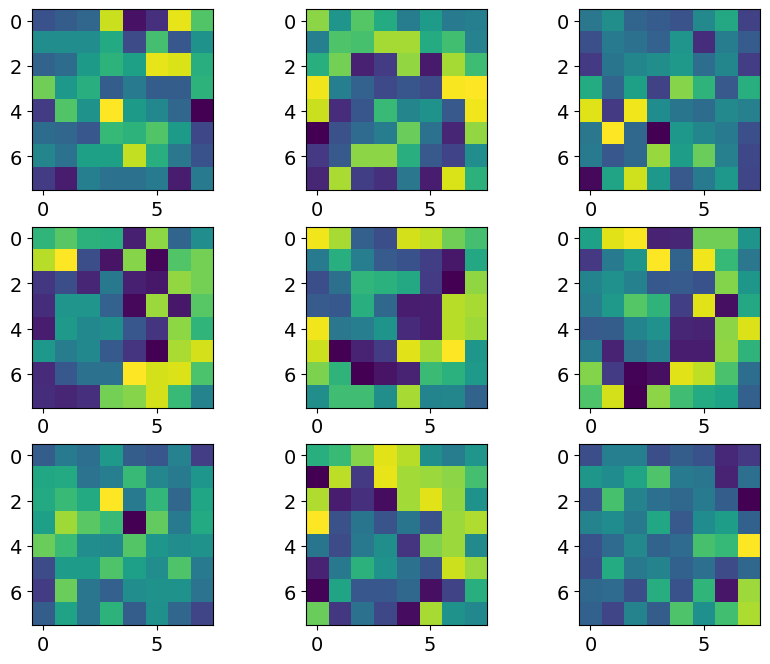

In [60]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [61]:
images, positions = next(iter(train_loader)) 
print(f"read image batch, size->{images.size()}")
img = images[0].squeeze()
print(img)

read image batch, size->torch.Size([1000, 1, 8, 8])
tensor([[-0.7063, -0.7921, -0.6099, -0.5991, -0.3848, -0.6206, -0.6313, -0.6956],
        [-0.6206, -0.4062, -0.5027, -0.3955, -0.4491, -0.6635, -0.5670, -0.8135],
        [-0.5991, -0.6420, -0.4062, -0.5241, -0.4062, -0.4920, -0.3419, -0.8028],
        [-0.5670, -0.7170, -0.4812, -0.3205,  0.1618,  0.2797, -0.2347, -0.5134],
        [-0.4277, -0.4384,  0.1726,  0.5477,  0.6870,  0.5584,  0.5584, -0.2454],
        [-0.6849, -0.4062,  0.4512,  0.8907,  1.9946,  1.6517,  1.0943,  0.3119],
        [-0.7278, -0.1490,  0.6442,  1.0193,  2.1661,  1.8875,  1.1693,  0.3655],
        [-0.6099, -0.5563,  0.0761,  0.8585,  1.5445,  1.3623,  0.7513,  0.0761]])


In [62]:
model = CNN_3x3(dropout=False).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()


CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [63]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
input data shape =>torch.Size([1000, 1, 8, 8])
(16,16,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/210, Loss: 470.06195068359375
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/210, Loss: 471.1167297363281


In [64]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=100)

Training with  ->210000 images
size of train loader  ->210 images
Evaluating with  ->60000 images
size of eval loader  ->60 images
Running for epochs ->10

EPOCH 0
Train Step 100/210, Loss: 157.19332885742188
Train Step 200/210, Loss: 70.51761627197266
--- EPOCH 0 AVG TRAIN LOSS: 169.01179575238908
--- EPOCH 0 AVG VAL LOSS: 63.294048118591306

EPOCH 1
Train Step 100/210, Loss: 30.069669723510742
Train Step 200/210, Loss: 13.451581001281738
--- EPOCH 1 AVG TRAIN LOSS: 31.436710062481108
--- EPOCH 1 AVG VAL LOSS: 11.840663766860962

EPOCH 2
Train Step 100/210, Loss: 6.966803073883057
Train Step 200/210, Loss: 6.424790382385254
--- EPOCH 2 AVG TRAIN LOSS: 7.8274922416323705
--- EPOCH 2 AVG VAL LOSS: 5.781840960184733

EPOCH 3
Train Step 100/210, Loss: 6.047445297241211
Train Step 200/210, Loss: 5.687796592712402
--- EPOCH 3 AVG TRAIN LOSS: 5.634144966942923
--- EPOCH 3 AVG VAL LOSS: 5.3231807788213095

EPOCH 4
Train Step 100/210, Loss: 4.856833457946777
Train Step 200/210, Loss: 5.4547810

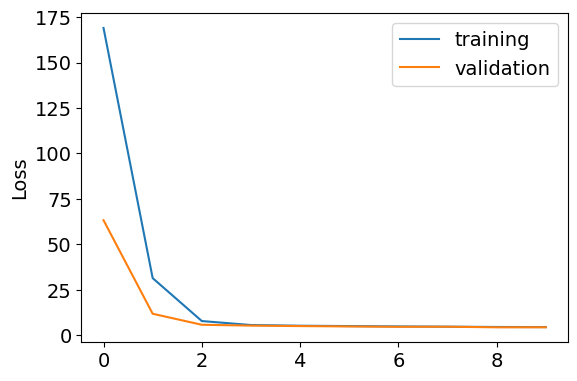

In [65]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))



In [66]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6)

/Users/jjgomezcadenas/Projects/pymono/pymono/aux_func.py:175: RuntimeWarning: invalid value encountered in sqrt
  weighted_sigma_x = np.sqrt(np.sum(image * (x_indices - weighted_mean_x)**2) / total_intensity)
/Users/jjgomezcadenas/Projects/pymono/pymono/aux_func.py:176: RuntimeWarning: invalid value encountered in sqrt
  weighted_sigma_y = np.sqrt(np.sum(image * (y_indices - weighted_mean_y)**2) / total_intensity)


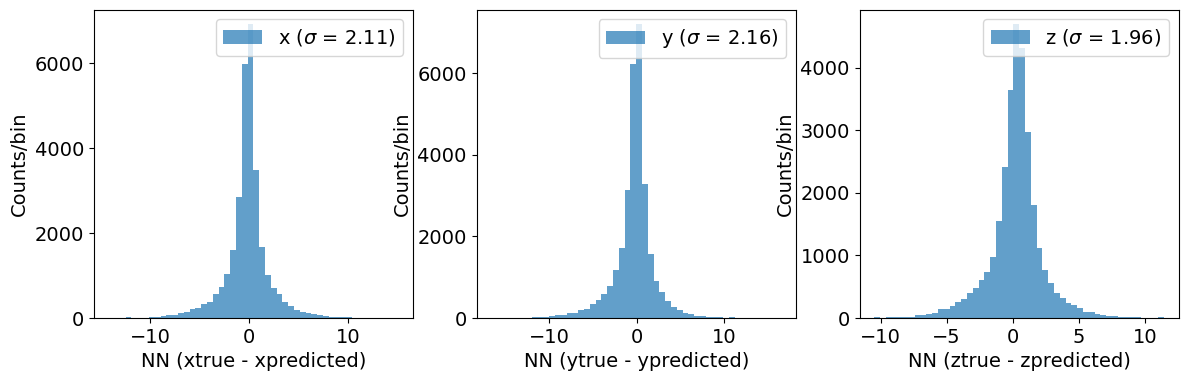

In [67]:
plotxyz(tdeltas, nbins=50)

In [68]:
def evaluate_cnn2(test_loader, model, device, pixel_size = 6):
    
    true_x, true_y, true_z = [],[],[]
    mean_x, mean_y = [],[]
    sigma_x, sigma_y = [],[]
    predicted_x, predicted_y, predicted_z = [],[],[]
    with torch.no_grad():

        model.eval()
        for i, (images, positions) in enumerate(test_loader):

            images = images.to(device)
            outputs = model(images).cpu()

            for x in positions[:,0]: true_x.append(x)
            for y in positions[:,1]: true_y.append(y)
            for z in positions[:,2]: true_z.append(z)

            for x in outputs[:,0]: predicted_x.append(x)
            for y in outputs[:,1]: predicted_y.append(y)
            for z in outputs[:,2]: predicted_z.append(z)

    # Convert to numpy arrays
    true_x = np.array(true_x); true_y = np.array(true_y); true_z = np.array(true_z)
    predicted_x = np.array(predicted_x); predicted_y = np.array(predicted_y); predicted_z = np.array(predicted_z)
    mean_x = np.array(mean_x); mean_y = np.array(mean_y)
    sigma_x = np.array(sigma_x); sigma_y = np.array(sigma_y)

    # Compute deltas for the NN.
    delta_x_NN = true_x - predicted_x
    delta_y_NN = true_y - predicted_y
    delta_z_NN = true_z - predicted_z

    tdeltas = namedtuple('tdeltas',
           'delta_x_NN, delta_y_NN, delta_z_NN')
    return tdeltas(delta_x_NN, delta_y_NN, delta_z_NN)



In [69]:
tdeltas = evaluate_cnn2(test_loader, model, device, pixel_size = 6)


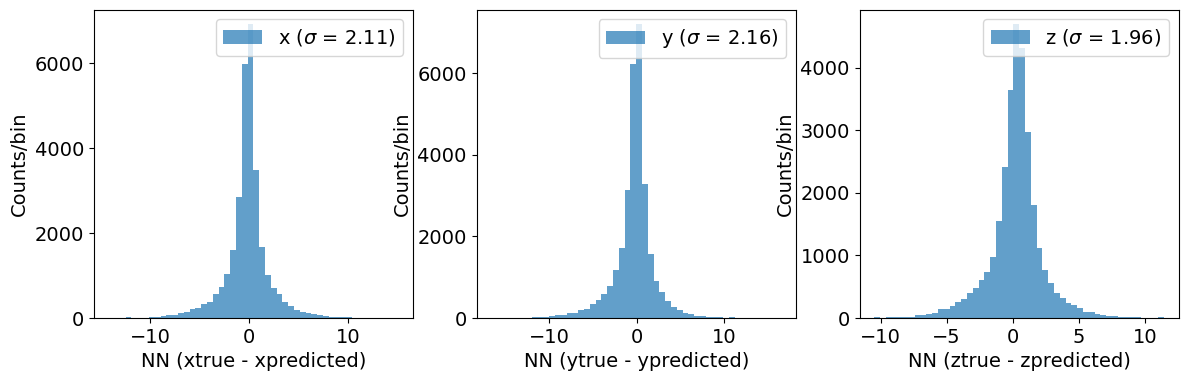

In [70]:
plotxyz(tdeltas, nbins=50)

## Add transformations

In [71]:
means, stds = get_means_stds(dir=CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX)

files in dir: 84
shape -> (10000, 8, 8)
mean img0 =166.796875
std  img0 =382.7119445800781


In [ ]:
len(means)

In [ ]:
means[0][0]

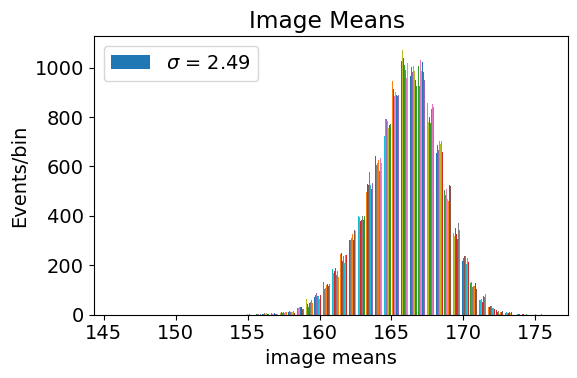

In [73]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

In [74]:
meansx =[np.mean(x) for x in means]

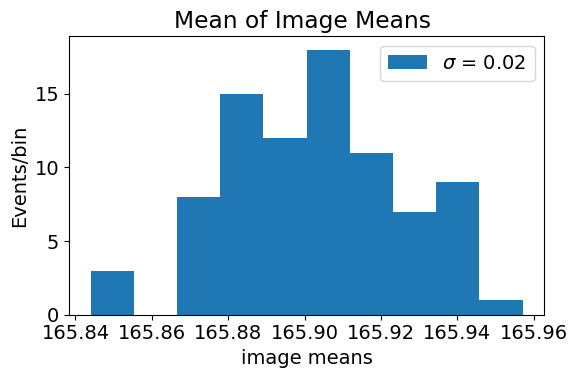

In [75]:
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [76]:
np.mean(meansx)

165.90295

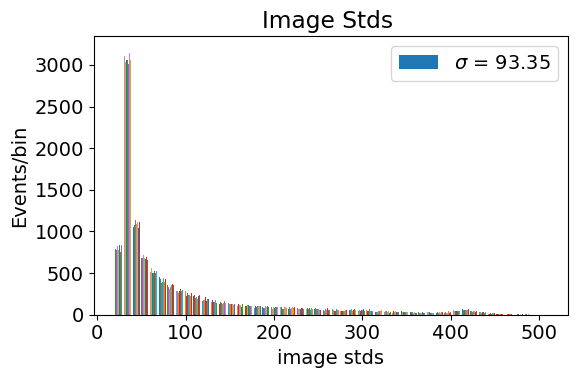

In [77]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

In [78]:
stdsx =[np.std(x) for x in stds]

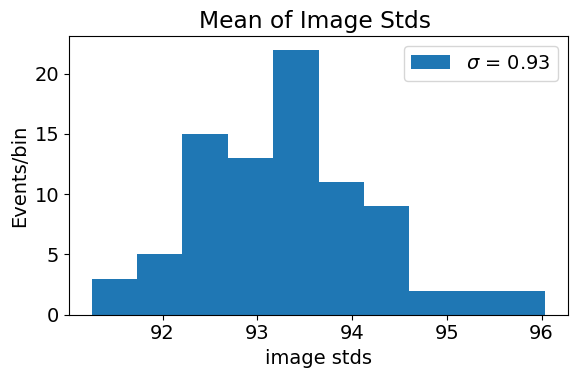

In [79]:
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [80]:
np.mean(stdsx)

93.342735

## Deeper networks

In [93]:
first_file = 0  # initial file indx
last_file  = 10  # lasta file indx
batch_size = 10  # Batch size

In [94]:
dataset = MonoDataset(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, 
                      first_file, last_file,
                      norm=True, resize=True, mean=165.90, std=93.3, size=(224, 224))


Running Monoataset with norm = True, resize=True
defining transform: componse Resize and Normalize
Loading files with indexes: [ 1  2  3  4 20 21 22 23 24 25]


In [95]:
dataset[2][0]

tensor([[[-0.5884, -0.5884, -0.5884,  ..., -0.7706, -0.7706, -0.7706],
         [-0.5884, -0.5884, -0.5884,  ..., -0.7706, -0.7706, -0.7706],
         [-0.5884, -0.5884, -0.5884,  ..., -0.7706, -0.7706, -0.7706],
         ...,
         [ 2.0911,  2.0911,  2.0911,  ..., -0.7599, -0.7599, -0.7599],
         [ 2.0911,  2.0911,  2.0911,  ..., -0.7599, -0.7599, -0.7599],
         [ 2.0911,  2.0911,  2.0911,  ..., -0.7599, -0.7599, -0.7599]]])

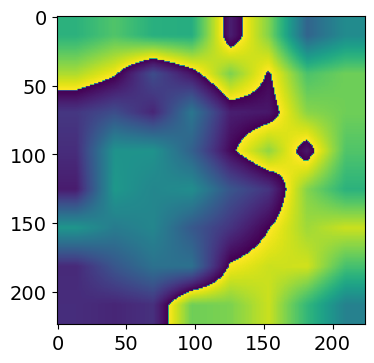

In [96]:
plot_image_ds(dataset, 3)

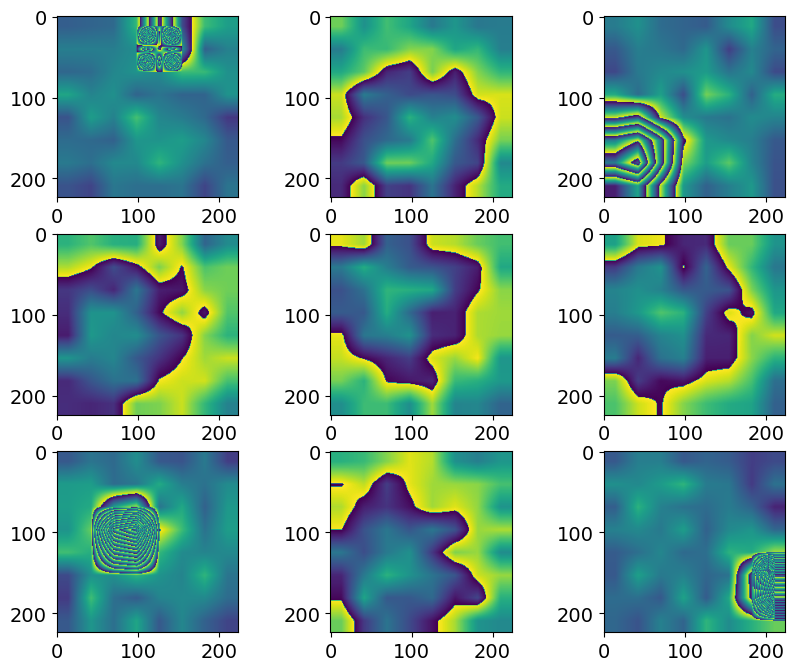

In [97]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [98]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=0.7, 
                                                                      val_fraction=0.2)

Loaded 100000 events
 train size = 70000
 val size = 20000
 test size = 10000
 train indices = range(0, 70000)
 val indices = range(70000, 90000)
 test indices = range(90000, 100000)
70000 training events (70.0%)
20000 validation events (20.0%)
10000 test events (10.0%)


read image batch, size->torch.Size([10, 1, 224, 224])


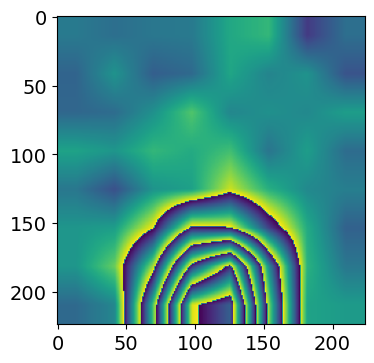

In [99]:
plot_image(train_loader, figsize=(4,4))

In [100]:
images, positions = next(iter(train_loader))

In [101]:
positions.shape

torch.Size([10, 3])

In [102]:
images.shape

torch.Size([10, 1, 224, 224])

In [110]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [109]:
class ResNet(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image (assumed 224 x 224) passes through a convolution (kernel 7x7) 
    with stride = 2 and padding = 3which increases the features from 3 to 64 and 
    reduces spatial dimensiones from 224 to (224 - 7 -2*3 +1)/2 =112, then batch normalization, 
    activation and MaxPool2d which further reduces dimensions to 56.
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, layers, num_classes = 3, debug=False):
        super(ResNet, self).__init__()
        self.debug = debug
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        if(self.debug): print(f" ResNet: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet: after conv1 =>{x.shape}")
            
        x = self.maxpool(x)
        if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet: after layer3 =>{x.shape}")
            
        x = self.avgpool(x)
        if(self.debug): print(f" ResNet: after avgpool =>{x.shape}")

        if(self.debug): print(f"(1,1,512) => (1,1,3) =>{x.shape}")
        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet: after flatten =>{x.shape}")
            
        x = self.fc(x)
        if(self.debug): print(f" ResNet: after fc =>{x.shape}")

        self.debug = False
        return x

In [111]:
#define the model
model = ResNet(ResBlock, [3, 4, 6, 3], debug=True).to(device)


 ## make_layer: planes = 64,  blocks = 3, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
layer block = 0: Block(in_channels=64, out_channels =64, stride = 1, downsample = None
 layer block = 1: Block(in_channels=64, out_channels =64, stride = 1, downsample = None
 layer block = 2: Block(in_channels=64, out_channels =64, stride = 1, downsample = None
 ## make_layer: planes = 128,  blocks = 4, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
layer block = 0: Block(in_channels=64, out_channels =128, stride = 2, downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 layer block = 1: Block(in_channels=128, out_channels =128, stride = 1, downsample = None
 layer block = 2

In [112]:
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [117]:
single_run(train_loader, device, model, optimizer, criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([10, 1, 224, 224])
labels = torch.Size([10, 3])
outputs = torch.Size([10, 3])
Train Step 1/7000, Loss: 505.75250244140625
i = 1
images = torch.Size([10, 1, 224, 224])
labels = torch.Size([10, 3])
outputs = torch.Size([10, 3])
Train Step 2/7000, Loss: 417.5830993652344


In [ ]:
first_file = 0  # initial file indx
last_file  = 10  # lasta file indx
batch_size = 10  # Batch size
epochs = 10

In [118]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=50)

Training with  ->70000 images
size of train loader  ->7000 images
Evaluating with  ->20000 images
size of eval loader  ->2000 images
Running for epochs ->10

EPOCH 0
Train Step 50/7000, Loss: 61.04550552368164
Train Step 100/7000, Loss: 54.42923355102539
Train Step 150/7000, Loss: 27.918718338012695
Train Step 200/7000, Loss: 44.370059967041016
Train Step 250/7000, Loss: 18.254655838012695
Train Step 300/7000, Loss: 16.71018409729004
Train Step 350/7000, Loss: 20.785926818847656
Train Step 400/7000, Loss: 16.499258041381836
Train Step 450/7000, Loss: 21.023487091064453
Train Step 500/7000, Loss: 10.186556816101074
Train Step 550/7000, Loss: 20.83084487915039
Train Step 600/7000, Loss: 17.339109420776367
Train Step 650/7000, Loss: 5.837975978851318
Train Step 700/7000, Loss: 7.483453750610352
Train Step 750/7000, Loss: 9.044965744018555
Train Step 800/7000, Loss: 27.88166618347168
Train Step 850/7000, Loss: 21.31263542175293
Train Step 900/7000, Loss: 23.509387969970703
Train Step 950/7

In [119]:
tdeltas = evaluate_cnn2(test_loader, model, device, pixel_size = 6)

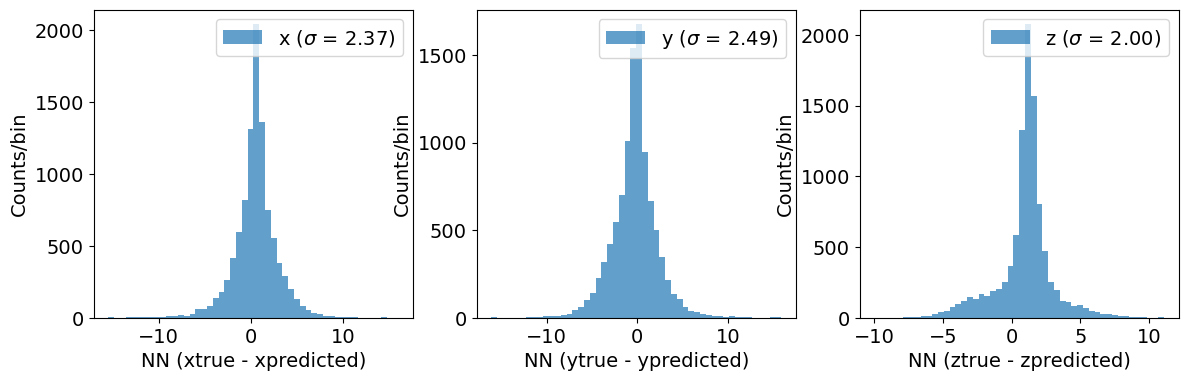

In [120]:
plotxyz(tdeltas, nbins=50)


In [ ]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))

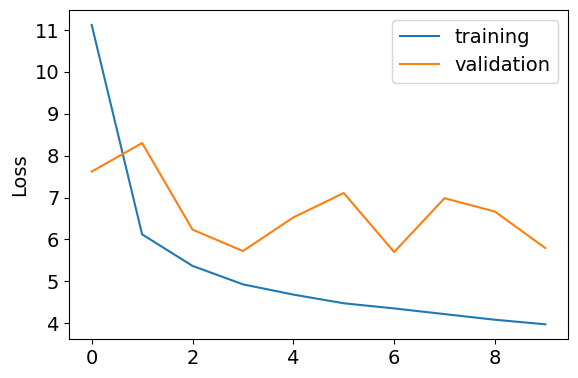

In [122]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
epochs = 10
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=50)

Training with  ->700000 images
size of train loader  ->7000 images
Evaluating with  ->200000 images
size of eval loader  ->2000 images
Running for epochs ->10

EPOCH 0
Train Step 50/7000, Loss: 2.4104325771331787
Train Step 100/7000, Loss: 3.3157763481140137
Train Step 150/7000, Loss: 1.2659865617752075
Train Step 200/7000, Loss: 2.2135188579559326
Train Step 250/7000, Loss: 2.1366326808929443
Train Step 300/7000, Loss: 1.7311956882476807
Train Step 350/7000, Loss: 4.414594650268555
Train Step 400/7000, Loss: 1.2160836458206177
Train Step 450/7000, Loss: 5.562794208526611
Train Step 500/7000, Loss: 2.344822883605957
Train Step 550/7000, Loss: 6.2520432472229
Train Step 600/7000, Loss: 3.689448118209839
Train Step 650/7000, Loss: 1.8138484954833984
Train Step 700/7000, Loss: 3.134577751159668
Train Step 750/7000, Loss: 2.209139585494995
Train Step 800/7000, Loss: 2.760110378265381
Train Step 850/7000, Loss: 5.1079630851745605
Train Step 900/7000, Loss: 0.9748588800430298
Train Step 950/

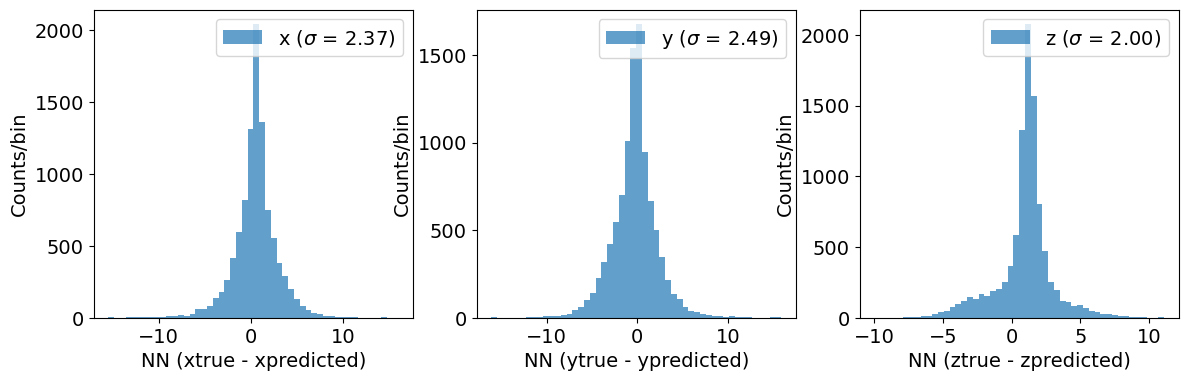

In [123]:
plotxyz(tdeltas, nbins=50)



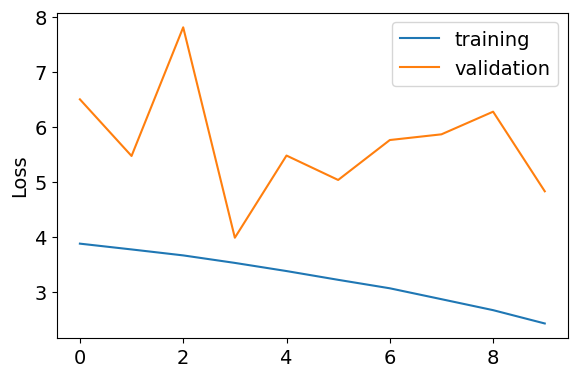

In [124]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))